Ada 3 model yang dikomparasikan saat menggunakan keseluruhan data, yaitu: Logistic Regression, Bernoulli Naive Bayes, dan XGBoost Classifier.

Ada 8 model yang dikomparasikan pada notebook selanjutnya yang berjudul "Notebook_Sampling_Data.ipynb", yaitu Logistic Regression, Support Vector Machine, Bernoulli Naive Bayes, Decision Tree Classifier, Random Forest Classifier, XGBoost Classifier, Catboost Classifier, dan Convolutional Neural Network.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import joblib

from sklearn.metrics import r2_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [18]:
column_name = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [19]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1', names=column_name)

In [20]:
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [21]:
df.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

In [22]:
df.shape

(1600000, 2)

In [23]:
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [24]:
df['sentiment'] = df['sentiment'].replace(4, 1)

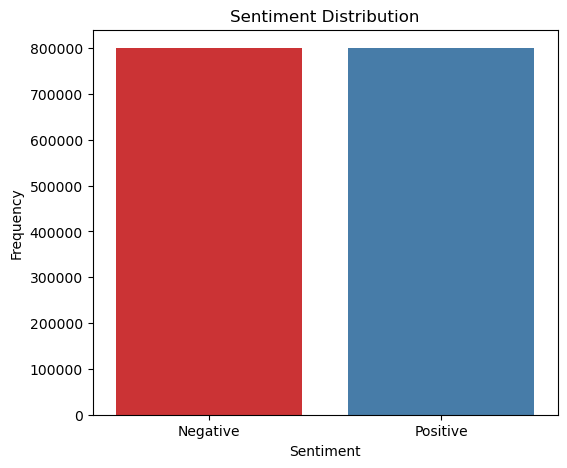

In [25]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set1')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(range(len(sentiment_counts)), ['Negative', 'Positive'])
plt.show()

Tampak distribusi kelasnya seimbang sehingga tidak membutuhkan imbalanced data handling.

In [26]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
def cleanText(text):
    cleanedText = []

    links = r'http\S+|www\S+|https\S+'
    userPattern = '@[^\s]+'
    apostrophe = r"'"
    nonWord = r'\W'
    singleCharacter = r'\s+[a-zA-Z]\s+'
    caretSymbol = r'\^[a-zA-Z]\s+'
    alphabet = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    multiSpace = r'\s+'

    text = text.lower()

    text = re.sub(links, ' ', text, flags=re.MULTILINE)

    text = re.sub(userPattern,' ', text)
    text = re.sub(apostrophe, '', text)
    text = re.sub(nonWord, ' ', text)
    text = re.sub(singleCharacter, ' ', text)
    text = re.sub(caretSymbol, ' ', text) 
    text = re.sub(alphabet, " ", text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    text = re.sub(multiSpace, ' ', text, flags=re.I)
    text = text.strip()
    
    wordLemm = WordNetLemmatizer()

    words = ''
    for word in text.split():
        if len(word)>1:
            if word != 'was':
                word = wordLemm.lemmatize(word)
            words += (word+' ')

    cleanedText.append(words)

    lemmatizedText = ' '.join(cleanedText)

    words = lemmatizedText.split()

    custom_stopwords = {'amp', 'quot', 'im', 'day'}
    words = [word for word in words if word not in custom_stopwords]

    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [30]:
df['cleaned_text'] = df['text'].apply(lambda x: cleanText(x))

In [ ]:
# df.to_csv('cleaned_data_all.csv', index=False)

In [ ]:
# df = pd.read_csv('cleaned_data_all.csv')

In [33]:
df.isnull().sum()

sentiment       0
text            0
cleaned_text    0
dtype: int64

In [34]:
df.dropna(inplace=True)

In [36]:
X = df['cleaned_text']
y = df['sentiment']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [39]:
X_train_tfidf.shape, X_test_tfidf.shape

((1280000, 50000), (320000, 50000))

In [41]:
nama_model_sentiment = []
scoreTrainArr = []
scoreTestArr = []
precisionArr = []
recallArr = []
f1Arr = []

def pred_model(model, X_train, y_train, X_test, y_test, nama_model):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    scoreTrain = accuracy_score(y_train, y_pred_train)
    scoreTest = accuracy_score(y_test, y_pred_test)
    
    nama_model_sentiment.append(nama_model)
    scoreTrainArr.append(scoreTrain)
    scoreTestArr.append(scoreTest)
    
    print("=====================================================")
    print("Evaluasi Akurasi Model:")
    print("Training Accuracy :", scoreTrain)
    print("Testing Accuracy :", scoreTest)
    
    print("=====================================================")
    
    print("\nClassification report untuk data test:")
    cr = classification_report(y_test, y_pred_test)
    print(cr)

    cr2 = classification_report(y_test, y_pred_test, output_dict=True)
    precisionArr.append(cr2['macro avg']['precision'])
    recallArr.append(cr2['macro avg']['recall'])
    f1Arr.append(cr2['macro avg']['f1-score'])
    
    print("=====================================================")
    
    confusion_matrix_percent = confusion_matrix(y_test, y_pred_test)
    confusion_matrix_df = pd.DataFrame(confusion_matrix_percent, index=model.classes_, columns=model.classes_)

    plt.figure()
    heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='.0f', cmap='YlGnBu')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,  fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0,  fontsize=14)

    plt.title('Confusion Matrix untuk Data Test', fontsize=18, color='darkblue')
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()

In [ ]:
clf_logreg = LogisticRegression(random_state=42).fit(X_train_tfidf, y_train)
clf_bnb = BernoulliNB().fit(X_train_tfidf, y_train)
clf_xgboost = XGBClassifier(random_state=42).fit(X_train_tfidf, y_train) 

Evaluasi Akurasi Model:
Training Accuracy : 0.83250390625
Testing Accuracy : 0.821134375

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



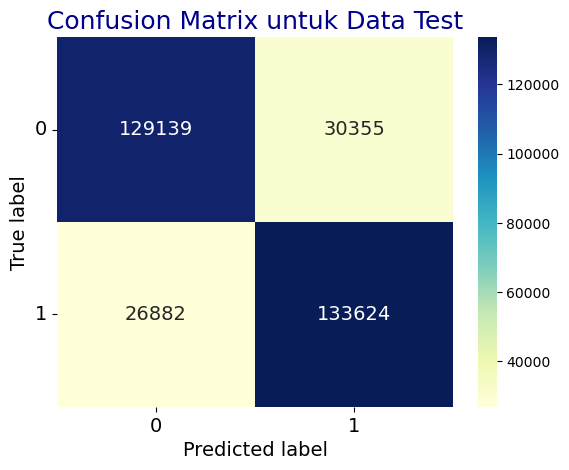

In [44]:
pred_model(clf_logreg, X_train_tfidf, y_train, X_test_tfidf, y_test, 'Logistic Regression')

Evaluasi Akurasi Model:
Training Accuracy : 0.79583203125
Testing Accuracy : 0.791034375

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79    159494
           1       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



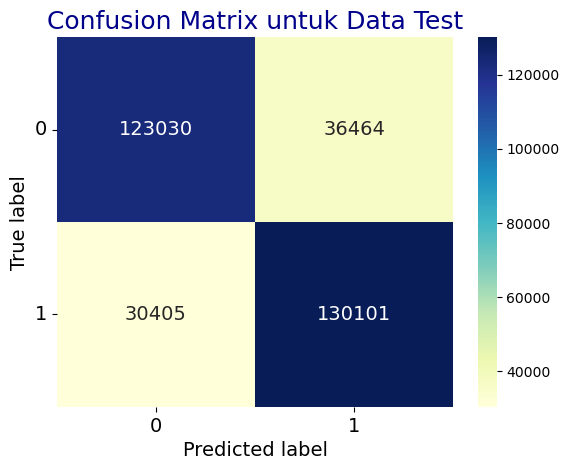

In [46]:
pred_model(clf_bnb, X_train_tfidf, y_train, X_test_tfidf, y_test, 'Bernoulli NB')

Evaluasi Akurasi Model:
Training Accuracy : 0.77320546875
Testing Accuracy : 0.76856875

Classification report untuk data test:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76    159494
           1       0.75      0.82      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



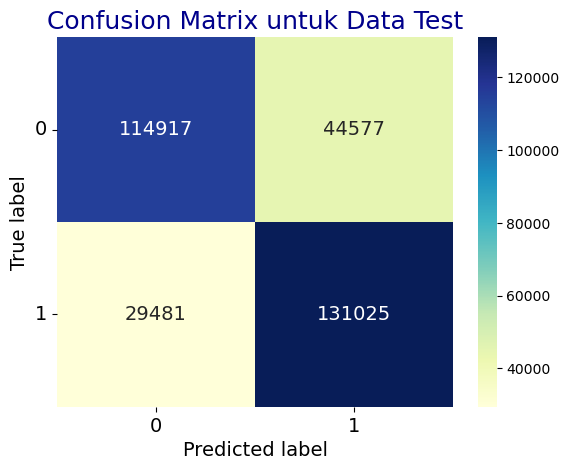

In [51]:
pred_model(clf_xgboost, X_train_tfidf, y_train, X_test_tfidf, y_test, 'XGBoost')

In [52]:
df_result_score_sentiment = pd.DataFrame({
    'Model': nama_model_sentiment,
    'Train Score': scoreTrainArr,
    'Test Score': scoreTestArr,
    'Precision': precisionArr,
    'Recall': recallArr,
    'F1 Score': f1Arr
})

In [53]:
df_result_score_sentiment = df_result_score_sentiment.sort_values(by='F1 Score', ascending=False)
df_result_score_sentiment

,Model,Train Score,Test Score,Precision,Recall,F1 Score
0,Logistic Regression,0.832504,0.821134,0.821294,0.821098,0.821099
1,Bernoulli NB,0.795832,0.791034,0.791460,0.790972,0.790932
2,XGBoost,0.773205,0.768569,0.770991,0.768417,0.767981


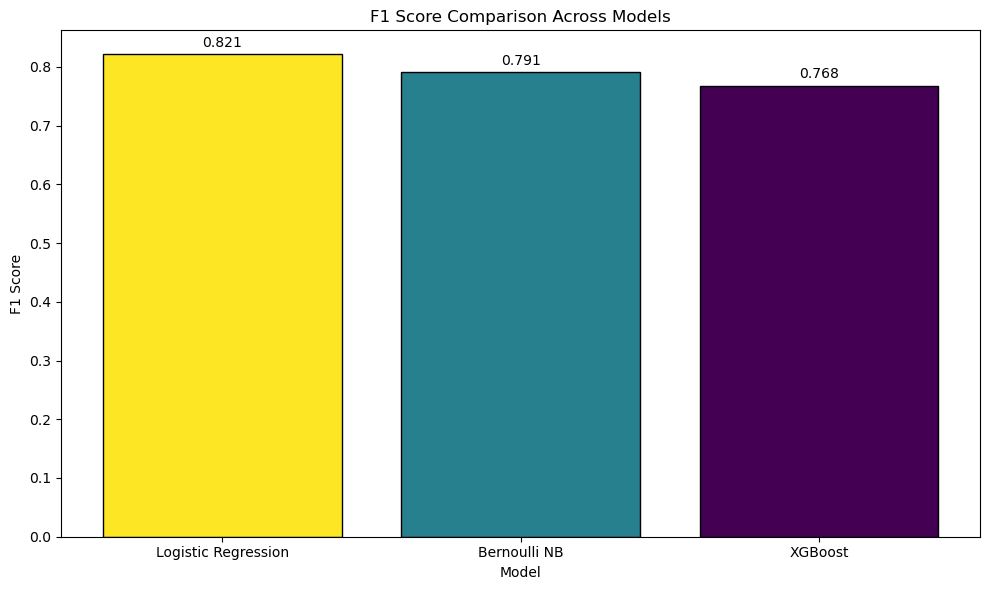

In [54]:
norm = plt.Normalize(df_result_score_sentiment['F1 Score'].min(), df_result_score_sentiment['F1 Score'].max())
colors = plt.cm.viridis(norm(df_result_score_sentiment['F1 Score'].values))

plt.figure(figsize=(10, 6))
bars = plt.bar(df_result_score_sentiment['Model'], df_result_score_sentiment['F1 Score'], edgecolor='black', color=colors)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), 
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Models')
plt.tight_layout()
plt.show()